In [1]:
import numpy as np
import random 

In [2]:
G = 4*np.pi**2
c = 63197.8
m1 =0.5
m2 = 0.5
M = m1+m2
mu = m1*m2/M

In [3]:
#Define the differential equation that describes the newtonian dynamics.
def ODE(q0):
    '''
    ------------------------------------------
    ODE(q0) 
    ------------------------------------------
    ODEs system corresponding to the forces.
    ------------------------------------------
    Arguments:
    q0: NumPy array with the coordinates 
        defined as.
    q0[0] = x: coordinate x.
    q0[1] = y: coordinate y.
    ------------------------------------------
    Returns:
    a = NumPy array with the components of the 
        acceleration.
    '''
    r2 = q0[0]**2 + q0[1]**2
    a = - G*M*q0[0:2]/r2**(3/2)
    return a


In [4]:
#We will use a Velocity-Verlet integrator
def velocityVerletIntegrator(ODE,q,dt):
    '''
    ---------------------------------
    VelocityVerletIntegrator(ODE,q)
    ---------------------------------
    Uses a velocity Verlet integrator 
    to obtain the velocity 
    and position at the next step.
    ---------------------------------
    Arguments:
    ODE: Force function.
    q: numpy array with the state of 
        the system in the order.
    q[0] = x: x coordinate.
    q[1] = y: y coordinate.
    q[2] = vx: velocity in x.
    q[3] = vy: velocity in y.
    ---------------------------------
    Returns:
    qNew: Numpy array with the updated state.
    '''
    qNew = np.zeros((4,)) #here will be the information of the new state
    #Calculate the new acceleration vector at t
    a0 = ODE(q) #Acceleration vector at t
    #Obtain the position at t+dt
    qNew[0:2] = q[0:2] + dt *q[2:4] + 0.5*a0* dt**2
    #Calculate the acceleration at t+dt
    a1 = ODE(qNew)
    #Calculate the velocity at t+dt
    qNew[2:4] = q[2:4] + (a0+a1)/2 * dt
    return qNew

In [5]:
n = 500000
# Initial Conditions
stateArray = np.zeros([n,4])
stateArray[0,0] = 1. # initial x
stateArray[0,1] = 0. # initial y
stateArray[0,2] = 0. # initial vx
stateArray[0,3] = 3. # initial vy
dt = 1E-5
for i in range(1,n):
    stateArray[i,:] = velocityVerletIntegrator(ODE, stateArray[i-1,:],dt)


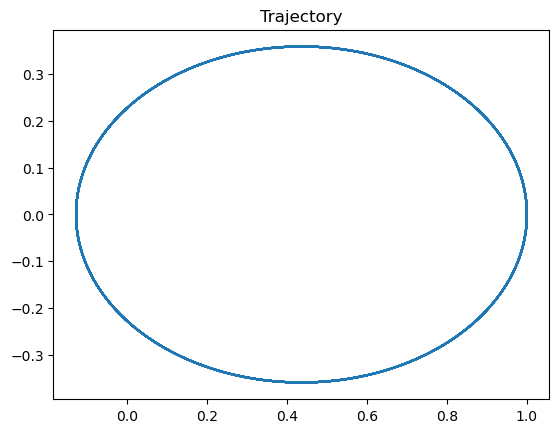

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Trajectory')
plt.plot(stateArray[:,0],stateArray[:,1])
plt.show() #The integrator works

In [7]:
#Define the model for the emision of energy and angular momentum.
def emissionModel(q,dE,dL):
    '''
    -----------------------------------
    EmissionModel(q,dE,dL)
    -----------------------------------
    Models the change in velocity after
    an emission of both energy and 
    angular momentum. The details 
    of the model and the derivation of the 
    emission matrix can be found in the 
    document emissionModel.pdf, in the 
    theory directory of the repository.
    -----------------------------------   
    Arguments:
    q: numpy array with the state of 
        the system in the order.
    q[0] = x: x coordinate.
    q[1] = y: y coordinate.
    q[2] = vx: velocity in x.
    q[3] = vy: velocity in y.
    dE: change in energy i.e. energy emited.
    dL: change in angula r momentum 
        i.e. angular momentum emited.
    -----------------------------------
    Returns:
    qNew: numpy array with the updated state
    '''
    #Where the information of the updated state will be
    qNew = np.zeros((4,))
    qNew[0:2] = q[0:2] 
    #Update the velocities 
    R = q[0]*q[2]+q[1]*q[3]
    qNew[2] = q[2] + (dE*q[0] - dL*q[3])/R
    qNew[3] = q[3]+ (q[1]*dE + dL*q[2])/R
    return qNew

In [8]:
#Define the quadrupole tensor that describes the radiation
def qij(x):
  '''
  --------------------------------------------------
  qij(x)
  --------------------------------------------------
  Obtains the components of the quadrupole tensor.
  --------------------------------------------------
  Arguments:
  x: numpy array with the position vector.
  --------------------------------------------------
  Returns:
  Q: quadrupole tensor
  '''
  return mu*(np.outer(x,x) - np.identity(2)*np.dot(x,x)/3) #Notice that the dimension of the identity is 2, not 3.

#Taken from: https://github.com/ashcat2005/binary_coalescence/blob/main/main/main.py

In [9]:
#Define the Levi-Civita tensor
ciclicPermutation = [[0,1,2],[1,2,0],[2,0,1]]
leviCivita = np.zeros((3,3,3))
for i in range(3):
    for j in range(3):
        for k in range(3):
            if i!=j and j!=k and i!=k:
                if [i,j,k] in ciclicPermutation:
                    leviCivita[i,j,k]=1
                else: leviCivita[i,j,k]=-1
print(np.shape(leviCivita))
print(leviCivita)

(3, 3, 3)
[[[ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0. -1.  0.]]

 [[ 0.  0. -1.]
  [ 0.  0.  0.]
  [ 1.  0.  0.]]

 [[ 0.  1.  0.]
  [-1.  0.  0.]
  [ 0.  0.  0.]]]


In [10]:
#Functions that calculate second and third derivative.
def second_derivative(f,h):
  '''
  Second derivative of a function  
  '''
  return (11*f[0] - 56*f[1] + 114*f[2] - 104*f[3] + 35*f[4])/(12*h**2)


def third_derivative(f,h):
  '''
  Third derivative of a function
  '''
  return (3*f[0] - 14*f[1] + 24*f[2] - 18*f[3] + 5*f[4])/(2*h**3)
#Taken from: https://github.com/ashcat2005/binary_coalescence/blob/main/main/main.py

In [11]:
#Define the loss of energy and angular momentum due to the GW emission.
def dEnergy(Qlist,dt):
    '''
     ------------------------------------
    dEnergy(Q)
    -------------------------------------
    Models the emission of energy in GW
    according to the theoretical results.
    -------------------------------------
    Arguments:
    Q: quadrupole tensor as a numpy array.
    -------------------------------------
    Returns:
    dE: change in energy
    '''
    a = third_derivative(Qlist,dt)
    b = 0
    for i in range(np.shape(a)[0]): #This can be more elegantly written as an iteration over the array elements
        for j in range(np.shape(a)[1]):
            b = b + a[i,j]**2
    dE = b*G/(5*c**2) * dt
    return dE
            
def dAngularMomentum(Qlist,dt):
    '''
     ------------------------------------
    dAngularMomentum(Q)
    -------------------------------------
    Models the emission of angular momentum 
    due to GW according to the theoretical 
    results.
    -------------------------------------
    Arguments:
    Q: quadrupole tensor as a numpy array.
    -------------------------------------
    Returns:
    dL: change in angular momentum
    '''
    z = 2
    a = second_derivative(Qlist,dt)
    b = 0
    for j in range(2):
        for k in range(2):
            for m in range(2): #This can be more elegantly written as an iteration over the array
                b = b + leviCivita[z,j,k]*a[j,m]*a[k,m]
    dL = 2*G/(5*c**5) * dt
    return dL
                
            


In [12]:
Q = np.zeros((n,2,2)) #The quadrupole tensor is stored here

In [16]:
n = 500000 #number of steps
dt = 1E-5
# Initial Conditions
stateArray = np.zeros([n,4]) #the information of the steps is stored here
stateArray[0,0] = 1. # initial x
stateArray[0,1] = 0. # initial y
stateArray[0,2] = 0. # initial vx
stateArray[0,3] = 3. # initial vy

Q = np.zeros((n,2,2)) #The quadrupole tensor is stored here
Q[0] = qij(stateArray[0,0:2]) # Quadrupole tensor initial conditions

for i in range(4): #Do 4 Verlet steps, we need four points to calculate the second and third derivative of q.
    stateArray[i+1]= velocityVerletIntegrator(ODE,stateArray[i],dt)
    Q[i+1] = qij(stateArray[i+1,0:2])
print(stateArray)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  3.00000000e+00]
 [ 9.99999998e-01  3.00000000e-05 -3.94784177e-04  2.99999999e+00]
 [ 9.99999992e-01  5.99999999e-05 -7.89568355e-04  2.99999998e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [17]:

#Main Loop
    
for i in range(4,n-1):
    #1)Do a Velocity VerletStep
    stateArray[i+1] = velocityVerletIntegrator(ODE,stateArray[i],dt)
    #2)Now emmit the GW
    #2.1)Calculate the quadrupole tensor
    Q[i+1]= qij(stateArray[i+1,0:2])
    #2.2)Calculate the emission of energy and angular momentum
    dE = dEnergy(Q[i-4:i+1],dt)
    dL = dAngularMomentum(Q[i-4:i+1],dt)
    #2.3)Update the velocities
    stateArray[i+1] = emissionModel(stateArray[i+1],dE,dL)

ERROR:root:No traceback has been produced, nothing to debug.
<ipython-input-3-c3d0b2e9d6b5>:20: RuntimeWarning: overflow encountered in double_scalars
  a = - G*M*q0[0:2]/r2**(3/2)
<ipython-input-11-9669868fb307>:45: RuntimeWarning: overflow encountered in double_scalars
  b = b + leviCivita[z,j,k]*a[j,m]*a[k,m]
<ipython-input-11-9669868fb307>:45: RuntimeWarning: invalid value encountered in double_scalars
  b = b + leviCivita[z,j,k]*a[j,m]*a[k,m]
<ipython-input-3-c3d0b2e9d6b5>:20: RuntimeWarning: invalid value encountered in true_divide
  a = - G*M*q0[0:2]/r2**(3/2)
<ipython-input-8-172bd10f6de1>:15: RuntimeWarning: invalid value encountered in multiply
  return mu*(np.outer(x,x) - np.identity(2)*np.dot(x,x)/3) #Notice that the dimension of the identity is 2, not 3.
<ipython-input-8-172bd10f6de1>:15: RuntimeWarning: invalid value encountered in subtract
  return mu*(np.outer(x,x) - np.identity(2)*np.dot(x,x)/3) #Notice that the dimension of the identity is 2, not 3.


In [49]:
i = 4
q = stateArray[i+1]
dL = dAngularMomentum(Q[i-4:i+1],dt)
dE = dEnergy(Q[i-4:i+1],dt)
R = q[0]*q[2]+q[1]*q[3]
dvx= (dE*q[0] - dL*q[3])/R
dvy= (q[1]*dE + dL*q[2])/R
print(dvx)
print(dvy)
print(R)

-3.63844728507557e-07
-5.457671110754545e-11
-0.0015242847873184133


<ipython-input-41-d1fe952512a2>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)


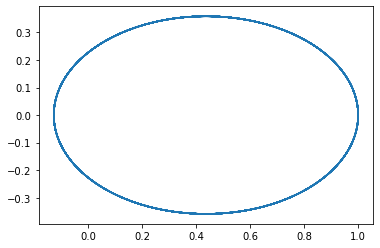

In [41]:
figure = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(stateArray[:,0],stateArray[:,1])